# Overview of the response functions available in Pastas
In this notebook an overview is provided of the response function that are available in Pastas. The below table summarizes all the response functions that are tested and supported. Others may be available but are not yet fully supported.

| Response function | No. of Parameters | Description
| :--- | :--- | :---      |  
|Exponential|2 - A, a         |Response function that can be used for stresses that have an (almost) instant effect.
|Gamma            |3 - A, a, n      |Response function commonly used for the groundwater response to precipitation and evaporation. This function is very versatile in its shape and is often used for other stresses as well.
|Hantush          |3 - A, Rho, Cs   |Response function commonly used for groundwater abstraction wells
|Bruggeman        |3 - a, b, c      |Response function commonly used for (river) water levels

In [1]:
import pastas as ps
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Parameters
**up** - This parameters determines whether the influence of the stress goes up or down, hence a positive or a negative response function.

**meanstress** - This parameter is used to estimante the initial value of the stationary effect of a stress. Hence the effect when a stress stays at an unit level for infinite amount of time.

**cutoff** - This parameter determines for how many time steps the response is calculated. This reduces calculation times as it reduces the length of the array the stress is convolved with. The default value is 0.99, meaning that the response is cutoff after 99% of the effect of the stress impuls has occurred. A minimum of length of three times the simulation time step is applied.




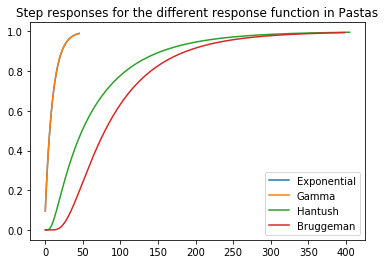

,initial,pmin,pmax,vary,name
Exponential_A,1,0,100,1,Exponential
Exponential_a,10,0.01,5000,1,Exponential
Gamma_A,1,0,100,1,Gamma
Gamma_n,1,0.1,10,1,Gamma
Gamma_a,10,0.01,5000,1,Gamma
Hantush_A,1,0,100,1,Hantush
Hantush_rho,1,0.0001,10,1,Hantush
Hantush_cS,100,0.001,1000,1,Hantush
Bruggeman_a,1,0,100,1,Bruggeman
Bruggeman_b,0.1,0,10,1,Bruggeman


In [2]:
# Exponential function
responses = {}
cutoff = 0.99 # 
meanstress = 1
up = True

Exp = ps.Exponential(up=up, meanstress=meanstress, cutoff=cutoff)
responses["Exponential"] = Exp

Gamma = ps.Gamma(up=up, meanstress=meanstress, cutoff=cutoff)
responses["Gamma"] = Gamma

Hantush = ps.Hantush(up=up, meanstress=meanstress, cutoff=cutoff)
responses["Hantush"] = Hantush

Bruggeman = ps.Polder(up=up, meanstress=meanstress, cutoff=cutoff)
responses["Bruggeman"] = Bruggeman

# Theis = ps.Theis(up=up, meanstress=meanstress, cutoff=cutoff)
# responses["Theis"] = Theis

parameters = pd.DataFrame()

for name, response in responses.items():
    p = response.set_parameters(name)
    parameters = parameters.append(p)
    plt.plot(response.step(p.initial), label=name)
plt.title("Step responses for the different response function in Pastas")
plt.legend()
plt.show()
parameters